In [1]:
import numpy as np
from numpy.random import rand
import random
import sympy as sp
import math
import matplotlib.pyplot as plt

## NVT Ensemble

In [2]:
def initialize_positions(num_particles, box_size):
    positions = np.random.rand(num_particles, 3) * box_size
    return positions


In [3]:
def lennard_jones_potential(r, epsilon=1.0, sigma=1.0, r_cut=2.5):
    if r < r_cut:
        U = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
        U_shift = 4 * epsilon * ((sigma / r_cut)**12 - (sigma / r_cut)**6)
        return U - U_shift
    else:
        return 0.0


In [4]:
def total_potential_energy(positions, box_size, epsilon=1.0, sigma=1.0, r_cut=2.5):
    num_particles = positions.shape[0]
    energy = 0.0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            rij = positions[i] - positions[j]
            rij -= box_size * np.round(rij / box_size)  # Apply minimum image convention
            r = np.linalg.norm(rij)
            if r < r_cut:
                energy += lennard_jones_potential(r, epsilon, sigma, r_cut)
    return energy


In [5]:
def monte_carlo_simulation(num_particles, box_size, num_steps, temperature, epsilon=1.0, sigma=1.0, r_cut=2.5):
    positions = initialize_positions(num_particles, box_size)
    initial_positions = positions.copy()  
    energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
    for step in range(num_steps):
        
        i = np.random.randint(num_particles)
        
    
        old_position = positions[i].copy()
        trial_position = old_position + (np.random.rand(3) - 0.5)
        
        
        trial_position = trial_position % box_size
        positions[i] = trial_position
        new_energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
        
        if new_energy < energy or np.random.rand() < np.exp((energy - new_energy) / temperature):
            energy = new_energy  
        else:
            positions[i] = old_position  
    
    return initial_positions, positions, energy

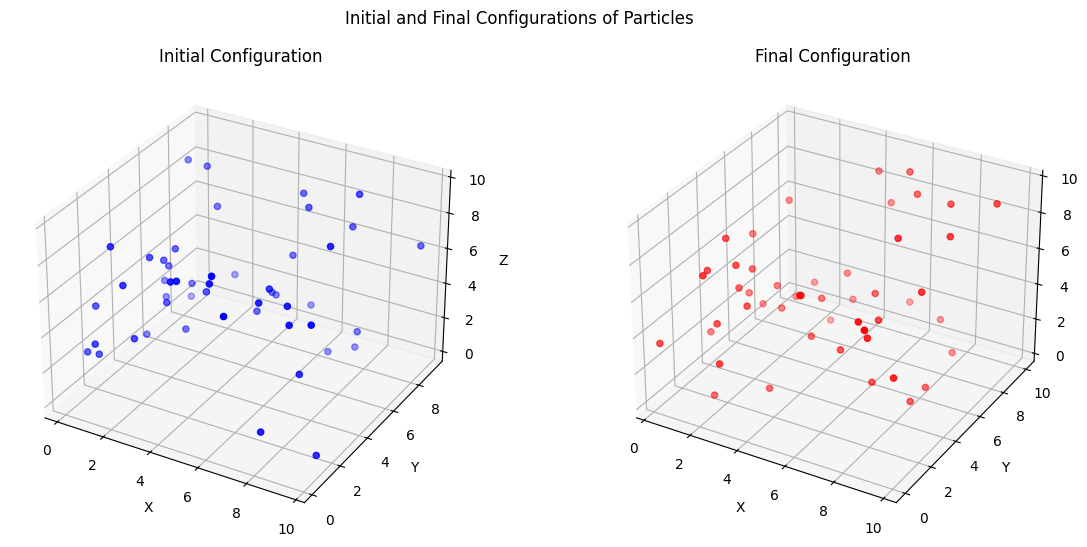

In [6]:
num_particles = 50
box_size = 10.0
num_steps = 1000
temperature = 1.0
epsilon = 1.0
sigma = 1.0
r_cut = 2.5

# Run the simulation
initial_positions, final_positions, final_energy = monte_carlo_simulation(num_particles, box_size, num_steps, temperature, epsilon, sigma, r_cut)

# Create side-by-side plots
fig = plt.figure(figsize=(14, 6))

# Initial configuration
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(initial_positions[:, 0], initial_positions[:, 1], initial_positions[:, 2], color='blue')
ax1.set_title('Initial Configuration')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Final configuration
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2], color='red')
ax2.set_title('Final Configuration')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('Initial and Final Configurations of Particles')
plt.show()

## NPT Ensemble

In [7]:
def volume_displacement(num_particles, positions, vmax, box_size, energy, pressure, temperature, epsilon=1.0, sigma=1.0, r_cut=2.5):
    vol = box_size**3
    dV = (2 * np.random.rand() - 1) * vmax
    new_vol = vol + dV
    if new_vol <= 0:
        return box_size  

    ln_new_vol = np.log(new_vol)
    ln_old_vol = np.log(vol)
    new_box_size = new_vol**(1.0/3.0)
    new_positions = positions * (new_box_size / box_size)
    new_energy = total_potential_energy(new_positions, new_box_size, epsilon, sigma, r_cut)
    
    delta_energy = new_energy - energy + pressure * (new_vol - vol) - num_particles * temperature * (ln_new_vol - ln_old_vol)
    if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / temperature):
        return new_box_size  
    else:
        return box_size  

def particle_displacement(num_particles, positions, energy, box_size, temperature, epsilon=1.0, sigma=1.0, r_cut=2.5):
    if num_particles == 0:
        return positions,energy 
    i = np.random.randint(num_particles)
    old_position = positions[i].copy()
    trial_position = old_position + (np.random.rand(3) - 0.5)
    trial_position = trial_position % box_size
    
    new_positions = positions.copy()
    new_positions[i] = trial_position
    new_energy = total_potential_energy(new_positions, box_size, epsilon, sigma, r_cut)
    
    delta_energy = new_energy - energy
    if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / temperature):
        return new_positions, new_energy  # Accept move
    else:
        return positions, energy  # Reject move

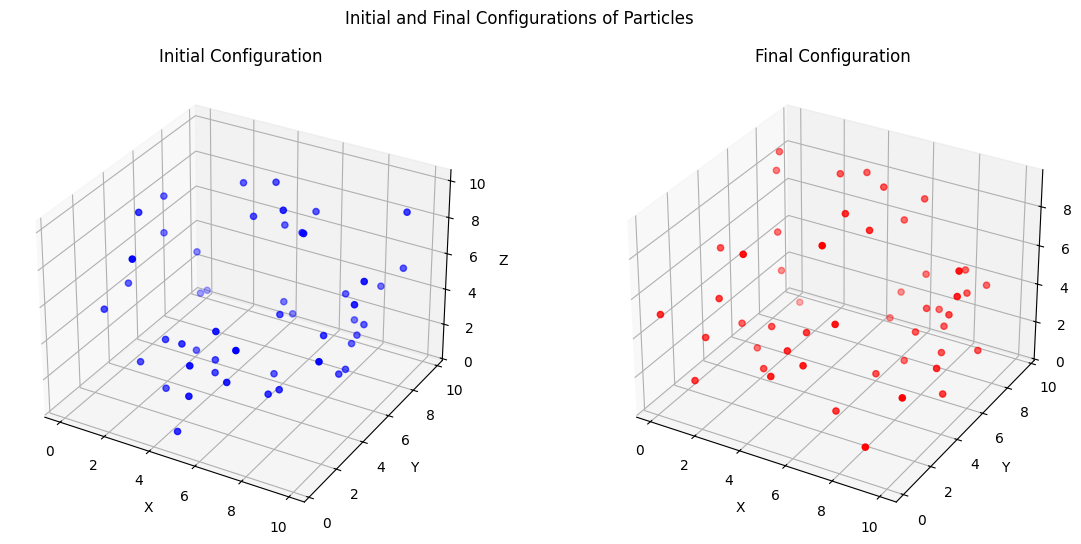

9.998940298836317


In [8]:
def mc_isothermal_isobaric(num_particles, box_size, num_steps, temperature, pressure, vmax, n, epsilon=1.0, sigma=1.0, r_cut=2.5):
    positions = initialize_positions(num_particles, box_size)
    initial_positions = positions.copy()  # Save initial positions
    energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
    
    for step in range(num_steps):
        prob = np.random.rand()
        if prob <= (1 / n):
            box_size = volume_displacement(num_particles, positions, vmax, box_size, energy, pressure, temperature, epsilon, sigma, r_cut)
        else:
            positions, energy = particle_displacement(num_particles, positions, energy, box_size, temperature, epsilon, sigma, r_cut)
    
    return initial_positions, positions, energy,box_size

# Example parameters
num_particles = 50
box_size = 10.0
num_steps = 1000
temperature = 1.0
pressure = 1.0
vmax = 0.1
n = 50
epsilon = 1.0
sigma = 1.0
r_cut = 2.5

# Run the simulation
initial_positions, final_positions, final_energy,final_box_size = mc_isothermal_isobaric(num_particles, box_size, num_steps, temperature, pressure, vmax, n, epsilon, sigma, r_cut)

# Create side-by-side plots
fig = plt.figure(figsize=(14, 6))

# Initial configuration
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(initial_positions[:, 0], initial_positions[:, 1], initial_positions[:, 2], color='blue')
ax1.set_title('Initial Configuration')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Final configuration
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2], color='red')
ax2.set_title('Final Configuration')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('Initial and Final Configurations of Particles')
plt.show()

print(final_box_size)

## Grand Canonical Ensemble

In [9]:
def particle_insertion_removal(num_particles, positions, box_size, energy,temperature, epsilon, sigma, r_cut):
    prob_insert = np.random.rand()
    prob_remove = 1 - prob_insert
    ra = np.random.rand()
    if num_particles == 0:
        positions,num_particles,energy = insert_particle(num_particles,positions,chem_potential,box_size,energy,temperature,epsilon,sigma,r_cut)
    
    if ra<=prob_insert:
        positions,num_particles,energy = insert_particle(num_particles,positions,chem_potential,box_size,energy,temperature,epsilon,sigma,r_cut)
    else:
        positions,num_particles,energy = remove_particle(num_particles,positions,chem_potential,box_size,energy,temperature,epsilon,sigma,r_cut)
    return positions,num_particles,energy

In [10]:
def insert_particle(num_particles, positions, chem_potential, box_size, energy, temperature, epsilon, sigma, r_cut):
    x_new = np.random.rand() * box_size
    y_new = np.random.rand() * box_size
    z_new = np.random.rand() * box_size
    new_coords = np.array([[x_new, y_new, z_new]])

    positions = np.vstack([positions, new_coords])
    new_energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
    volume = box_size ** 3
    delta_energy = new_energy - (chem_potential + energy)
    needed_exp = volume * np.exp(-delta_energy / temperature)

    if np.random.rand() < needed_exp:
        num_particles += 1
        energy = new_energy  # Update the energy to the new energy
    else:
        positions = np.delete(positions, num_particles, axis=0)

    return positions, num_particles,energy


In [11]:
def remove_particle(num_particles, positions, chem_potential, box_size, energy, temperature, epsilon, sigma, r_cut):
    if num_particles == 0:
        return positions, num_particles  # No particles to remove

    i = np.random.randint(num_particles)
    remove_particle_coords = positions[i].copy()
    positions = np.delete(positions, i, axis=0)
    new_energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
    volume = box_size ** 3
    delta_energy = (chem_potential + energy) - new_energy
    needed_exp = volume * np.exp(-delta_energy / temperature)

    if np.random.rand() < needed_exp:
        num_particles -= 1
        energy = new_energy  # Update the energy to the new energy
    else:
        positions = np.insert(positions, i, remove_particle_coords, axis=0)

    return positions, num_particles,energy


In [12]:
def grand_mc(num_particles, box_size, num_steps,chem_potential,temperature,epsilon=1.0, sigma=1.0, r_cut=2.5):
    positions = initialize_positions(num_particles, box_size)
    initial_positions = positions.copy()
    energy = total_potential_energy(positions, box_size, epsilon, sigma, r_cut)
    n = np.random.rand() #probability for insertion/removal
    
    for step in range(num_steps):
        prob = np.random.rand()
        if prob <= n:
            positions,num_particles,energy = particle_insertion_removal(num_particles, positions, box_size, energy,temperature, epsilon, sigma, r_cut)
        else:
            positions, energy = particle_displacement(num_particles, positions, energy, box_size, temperature, epsilon, sigma, r_cut)
    
    return initial_positions, positions, energy,num_particles

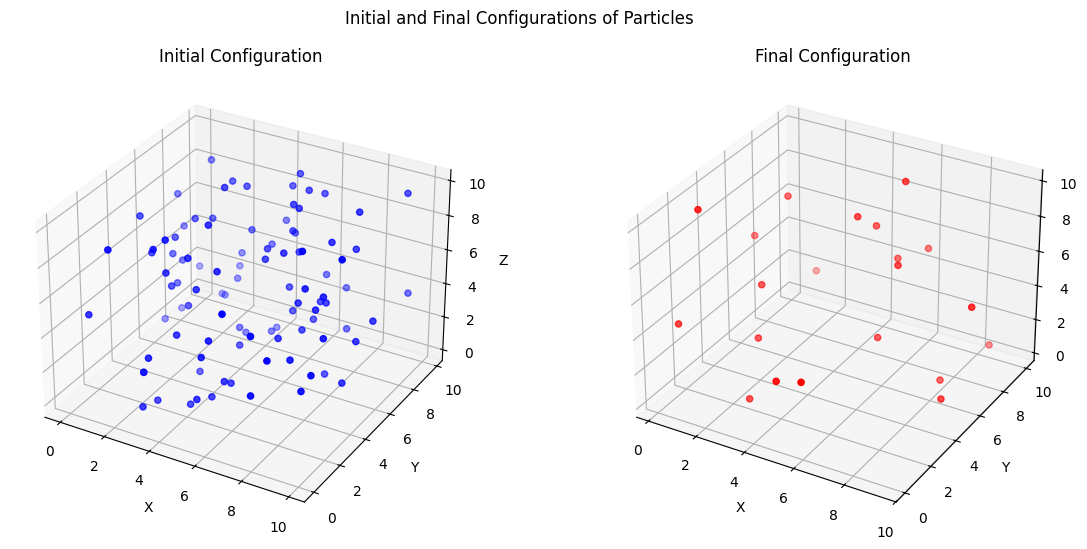

21


In [13]:
num_particles = 100
box_size = 10.0
num_steps = 10000
temperature = 1.0
chem_potential = 0.1
epsilon = 1.0
sigma = 1.0
r_cut = 2.5

# Run the simulation
initial_positions, final_positions, final_energy,final_num_particles = grand_mc(num_particles, box_size, num_steps,chem_potential,temperature,epsilon=1.0, sigma=1.0, r_cut=2.5)

# Create side-by-side plots
fig = plt.figure(figsize=(14, 6))

# Initial configuration
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(initial_positions[:, 0], initial_positions[:, 1], initial_positions[:, 2], color='blue')
ax1.set_title('Initial Configuration')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Final configuration
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2], color='red')
ax2.set_title('Final Configuration')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('Initial and Final Configurations of Particles')
plt.show()

print(final_num_particles)